In [1]:
import osmnx as ox
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import pprint
from shapely.geometry import Point
import networkx as nx
import json
from geopy.geocoders import Nominatim

In [33]:
def color_nodes(graph, visible_nodes):
    nc = []
    ns = []
    for node in graph.nodes:
        if node in visible_nodes:
            nc.append('#c7522a')
            ns.append(30)

        else: 
            nc.append('b')
            ns.append(0)
    return(nc, ns)

In [25]:
# Analysis location: Antakya, Turkey
n = 36.203219
e = 36.162786
s = 36.169400
w = 36.112595

corner1 = [n, e]
corner2 = [n, w]
corner3 = [s, e]
corner4 = [s, w]

plotsize = 4000           

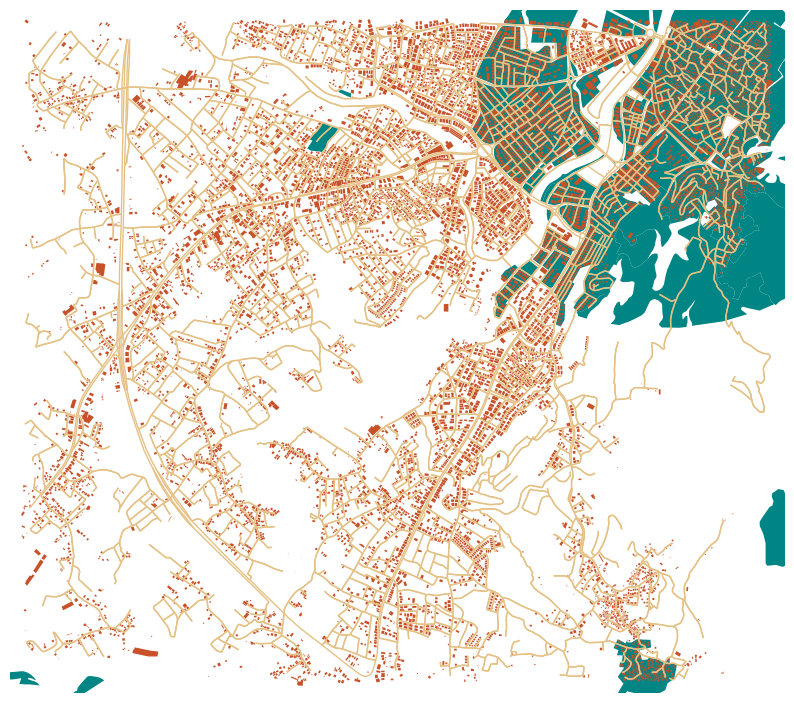

(<Figure size 1000x1000 with 1 Axes>, <AxesSubplot:>)

In [30]:
# graph = ox.graph_from_point(mylocation, 500, simplify=True)
# buildings = ox.features_from_point(mylocation, {'building': True}, 500)
buildings = ox.features_from_bbox(n,e,s,w, {'building': True})
landuse = ox.features_from_bbox(n,e,s,w, {'landuse': True})
graph = ox.graph_from_bbox(n,e,s,w, simplify=True)

fig, ax = ox.plot_footprints(landuse, color='#008585',  bgcolor='w', show=False, close=False, figsize=(10,10))
fig1, ax1 = ox.plot_footprints(buildings, ax = ax, color='#c7522a',  bgcolor='w', show=False, close=False, figsize=(10,10))
ox.plot_graph(graph, ax=ax1,  bgcolor='w', node_size=0, edge_color= '#e5c185', show=True, close=False, figsize=(10,10))

In [49]:
[36.200724, 36.131536]
[36.198916, 36.129690]
[36.198567, 36.132002]
[36.199512, 36.133424]
[36.200563, 36.132218]

df = pd.DataFrame(
    {   "Latitude": [36.200724, 36.198916, 36.198567, 36.199512, 36.200563],
        "Longitude": [36.131536, 36.129690, 36.132002, 36.133424, 36.132218],

    }
)

potential_shelterspot = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.Longitude, df.Latitude), crs="EPSG:4326"
)
shape = potential_shelterspot.dissolve().convex_hull

print(potential_shelterspot.head())
print(' ')
print(shape)

    Latitude  Longitude                   geometry
0  36.200724  36.131536  POINT (36.13154 36.20072)
1  36.198916  36.129690  POINT (36.12969 36.19892)
2  36.198567  36.132002  POINT (36.13200 36.19857)
3  36.199512  36.133424  POINT (36.13342 36.19951)
4  36.200563  36.132218  POINT (36.13222 36.20056)
 
0    POLYGON ((36.13200 36.19857, 36.12969 36.19892...
dtype: geometry


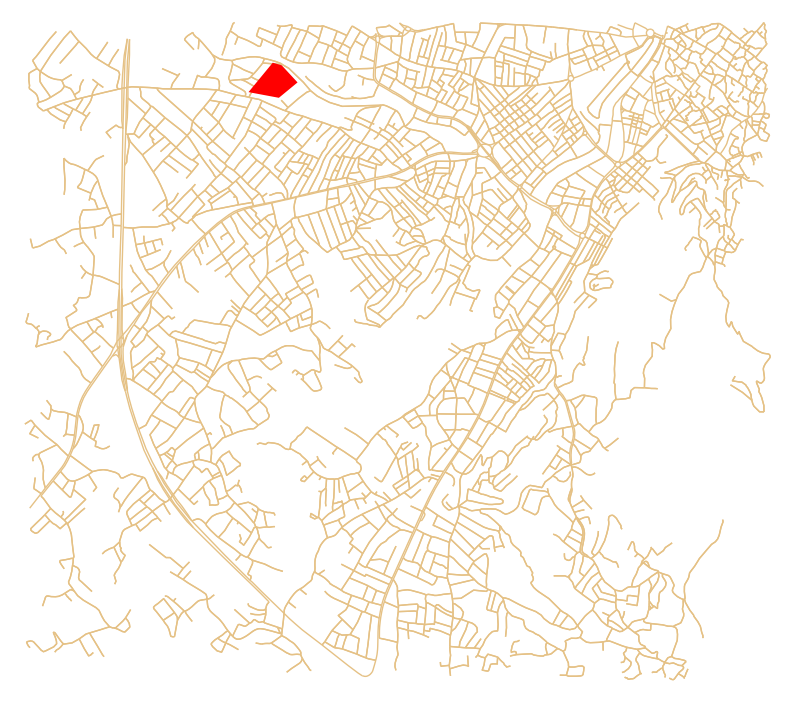

In [50]:
fig, ax = ox.plot_graph(graph, show=False, close=False, bgcolor='w', node_size=0, edge_color= '#e5c185',figsize=(10,10))
shape.plot(ax=ax, markersize = 20, color = "red" , alpha=1)
plt.show()

In [19]:
pathgraph = ox.graph_from_bbox(n,e,s,w, network_type="bike", simplify=True) # usually, these paths are 'tracks', local paths used for agriculture or forestry (unpaved, small)
truckgraph = ox.graph_from_bbox(n,e,s,w, network_type="drive", simplify=True)
walkgraph = ox.graph_from_bbox(n,e,s,w, network_type="walk", simplify=True)



In [ ]:
# click on google maps for close coordinate of the designated area: find closest area to the coordinates
mylocation = [36.195851, 36.134338]

# Determine the closest node to the input coordinate
lat_orig = mylocation[0]
lng_orig = mylocation[1]

nearest_node = ox.distance.nearest_nodes(truckgraph, lng_orig, lat_orig)
nc,ns = color_nodes(truckgraph, [nearest_node])

ox.plot_graph(truckgraph,  bgcolor='w', node_color = nc, node_size=ns, edge_color= '#e5c185', show=True, close=False, figsize=(10,10))

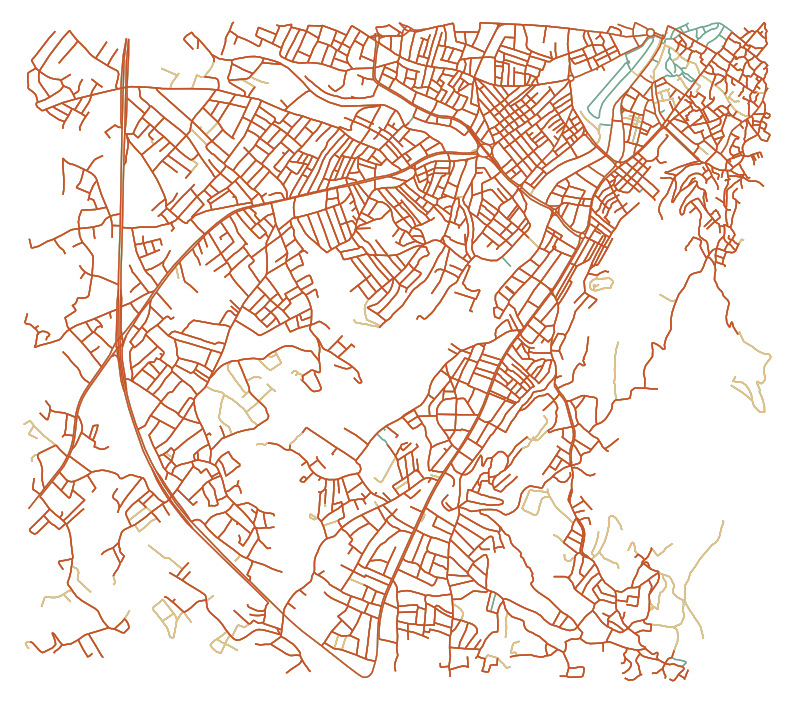

(<Figure size 1000x1000 with 1 Axes>, <AxesSubplot:>)

In [21]:

# Plot graph with the different types of transport
fig, ax = ox.plot_graph(walkgraph, bgcolor='w', node_size=0, show=False, close=False, edge_color='#74a892', figsize=(10,10))
fig2, ax2 = ox.plot_graph(pathgraph, ax=ax,  bgcolor='w', node_size=0, show=False, close=False, edge_color='#e5c185', figsize=(10,10))
ox.plot_graph(truckgraph, ax=ax2, bgcolor='w', node_size=0, show=True, close=False, edge_color='#c7522a', figsize=(10,10))


In [1]:
#add features needed for travel time calculations
speed_limit = []

edge_attr = nx.get_edge_attributes(truckgraph, 'highway')
edge_attr = edge_attr.items()

for edge in edge_attr: 
    # print(edge[1])
    if edge[1] == "primary":
        speed_limit.append(140)
    elif edge[1] == "secundary": 
        speed_limit.append(110)
    elif edge[1] == 'tertiary':
        speed_limit.append(70)
    elif edge[1] == "residential": 
        speed_limit.append(50)
    # elif edge is unclassified:
        #TODO: take average of all alligning edges
    else: 
        speed_limit.append(100)

        # take average of all alligning edges
print(speed_limit)
# print(edge_attr)
# speed_limit = dict(speed_limit)
# nx.set_edge_attributes(truckgraph, speed_limit)

# TODO try to look for a good aggregation function for missing roads 
ox.add_edge_speeds(truckgraph, hwy_speeds=speed_limit)
ox.add_edge_travel_times(truckgraph)

edge_attr = nx.get_edge_attributes(truckgraph, 'speed_kph')
edge_attr = edge_attr.items()
print(edge_attr)

#show plot with the travel time of each road
ec = ox.plot.get_edge_colors_by_attr(truckgraph, 'travel_time', cmap='RdYlBu')
print(ec)
ox.plot_graph(truckgraph, bgcolor='w', node_size=0, show=True, close=False, edge_color=ec, figsize=(10,10))

NameError: name 'nx' is not defined

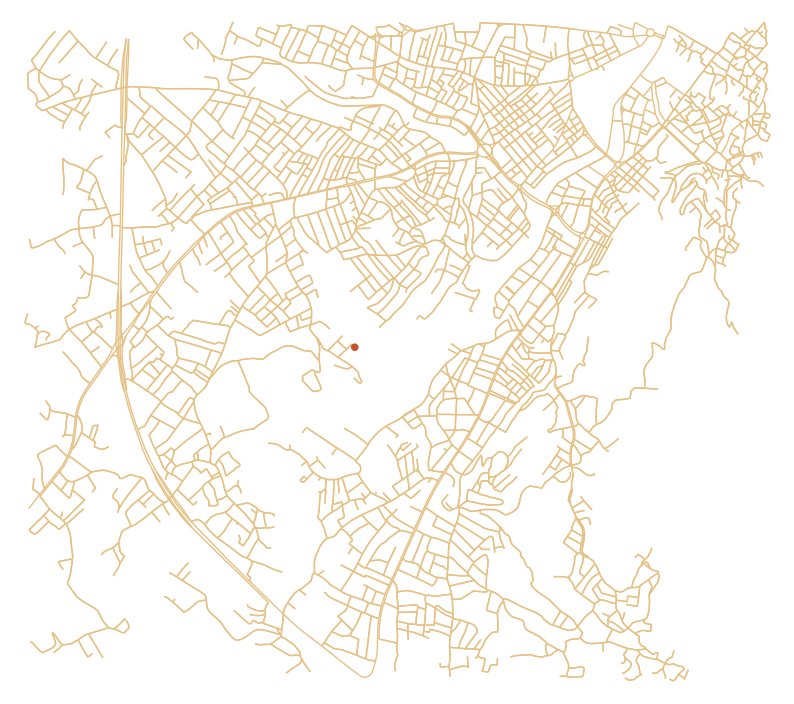

(<Figure size 1000x1000 with 1 Axes>, <AxesSubplot:>)

In [28]:
# Determine the closest node to the input coordinate
lat_orig = mylocation[0]
lng_orig = mylocation[1]

nearest_node = ox.distance.nearest_nodes(truckgraph, lng_orig, lat_orig)
nc,ns = color_nodes(truckgraph, [nearest_node])



nc,ns = color_nodes(truckgraph, [nearest_node])

# fig, ax = ox.plot_footprints(airports, color='#008585',  bgcolor='w', show=False, close=False, figsize=(10,10))
ox.plot_graph(truckgraph,  bgcolor='w', node_color = nc, node_size=ns, edge_color= '#e5c185', show=True, close=False, figsize=(10,10))

<class 'list'>


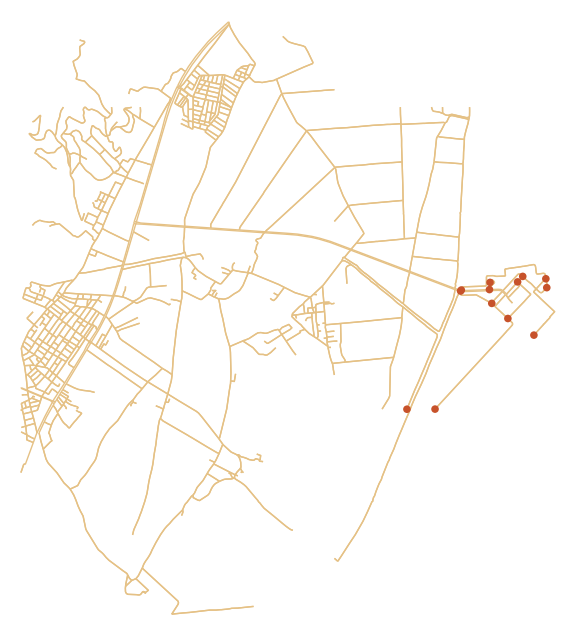

(<Figure size 800x800 with 1 Axes>, <AxesSubplot:>)

In [8]:
airports = {"aeroway": ['aerodrome', 'airport', 'helipad', 'runway']}
airports = ox.features_from_point(mylocation, airports, plotsize)

coords = airports.get_coordinates()
newnodes = ox.nearest_nodes(truckgraph, coords.x, coords.y)
print(type(newnodes))

nc, ns = color_nodes(truckgraph, newnodes)
ox.plot_graph(truckgraph, bgcolor='w', node_color=nc,  node_size=ns, edge_color='#e5c185')


C:\Users\maart\AppData\Local\Temp\ipykernel_24852\1199341203.py:8: UserWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in a future release. Use the `route_to_gdf` function instead.
  route_time = int(sum(ox.utils_graph.get_route_edge_attributes(truckgraph, route, "travel_time")))


the shortest route takes 149 seconds and leaves from 10631696204


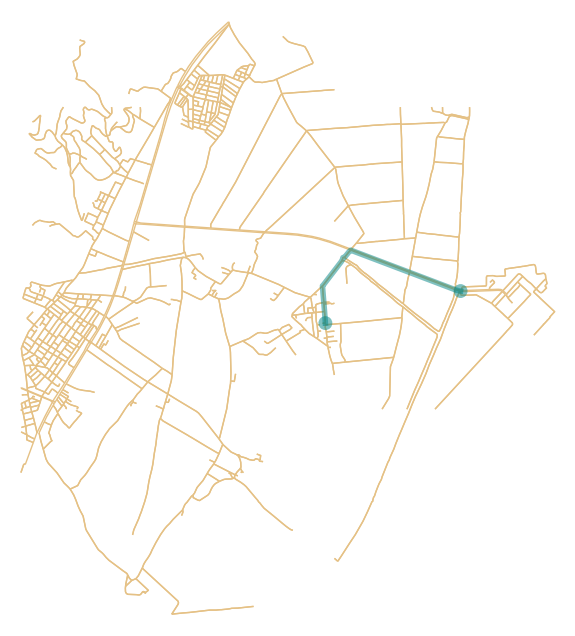

(<Figure size 800x800 with 1 Axes>, <AxesSubplot:>)

In [9]:
import math
orig = nearest_node
shortest_route_time = math.inf
closest_node = []
shortest_route = []
for dest_node in newnodes: 
    route = ox.shortest_path(truckgraph, orig, dest_node, weight = 'travel_time')
    route_time = int(sum(ox.utils_graph.get_route_edge_attributes(truckgraph, route, "travel_time")))
    # route_length = int(sum(ox.utils_graph.get_route_edge_attributes(truckgraph, route, "length")))
    if route_time < shortest_route_time: 
        shortest_route_time = route_time
        closest_node = dest_node
        shortest_route = route

print("the shortest route takes", shortest_route_time, "seconds", "and leaves from", closest_node)

ox.plot.plot_graph_route(truckgraph, shortest_route, bgcolor='w', route_color ='#008585', node_size=0,  edge_color='#e5c185')


In [10]:
# #save the route data as a json
gdf = ox.utils_graph.route_to_gdf(truckgraph, shortest_route)
gdf = gdf.to_json()
gdf = (json.dumps(gdf))

json_path = 'data/shortestroute.json' 
with open(json_path, "w") as f:
    f.write(gdf)